<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The Datasets

### HAM10000 - From the authors
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:

**akeic**  -  Actinic keratoses and intraepithelial carcinoma / Bowen's disease

**bcc** - basal cell carcinoma

**bkl** -  benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)

**df** - dermatofibroma

**mel** - melanoma

**nv** - melanocytic nevi

**vasc** -  vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

The test set is not public, but the evaluation server remains running (see the challenge website). Any publications written using the HAM10000 data should be evaluated on the official test set hosted there, so that methods can be fairly compared.

### DDI - From Authors

Dermatologists diagnose a wide range of skin disease, ranging from skin cancers to inflammatory conditions like atopic dermatitis and psoriasis. However, globally, an estimated 3 billion people have inadequate access to medical care for skin disease. Even in the United States, there is a shortage and unequal access to dermatologists leading to long wait times. One proposed solution is the use of artificial intelligence (AI) tools, which could help with triaging skin diseases and identifying individuals with potential skin diseases. There has been rapid development of algorithms which claim to detect cutaneous malignancies over the last few years. However, we recently published a review of AI datasets for dermatology and found that most datasets are not publicly available, lack important information about dataset diversity, and have noisy diagnostic labels. Currently, publicly available datasets lack biopsy-proven skin lesions in dark skin tones.

Labeling: The images included in the DDI dataset were retrospectively selected from reviewing pathology reports in Stanford Clinics from 2010-2020 with further details in our paper. There are 656 images representing 570 unique patients. Each image label was expertly curated: skin tone was labeled based on in-person evaluation at the clinic visit cross-referenced against demographic photos and review of the clinical images by two board certified dermatologists. Each diagnosis was based on pathology reports from biopsy: these reports and the corresponding image was reviewed by a board certified dermatologist and dermatopathologist.

Skin tone comparison: The dataset comprised a retrospective convenience sample across all images of Fitzpatrick I-VI but was also designed to allow direct comparison between Fitzpatrick I-II and Fitzpatrick V-VI by matching diagnostic category, age within 10 years, gender, and date of photograph within 3 years. The images are not meant to be text book examples but rather represent the kind of clinical photos that AI algorithms may encounter in practice. This design allows us to evaluate previously developed state-of-the-art diagnostic algorithms across skin tones. During the de-identification process prior to data release, some of the images were cropped further to protect patient privacy. However, the main lesions were preserved during this process.


In [ ]:
import zipfile
import os
import shutil

# path to zip files
zip_path_ham = "/content/drive/MyDrive/Datasets/skin_cancer/HAM1000/ham1000.zip" #Change this here! Link to your HAM10000.zip
extraction_path = "/content/unzipped_files"

# create directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# unzip files
with zipfile.ZipFile(zip_path_ham, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# create new directory to combine ham parts 1 and 2
new_dir = os.path.join(extraction_path, 'ham10k')
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# function to move files from source to destination
def move_files(source_dir, dest_dir):
    for file in os.listdir(source_dir):
        src_file = os.path.join(source_dir, file)
        dest_file = os.path.join(dest_dir, file)
        if not os.path.exists(dest_file):
            shutil.move(src_file, dest_dir)
        else:
            print(f"File already exists: {dest_file}")

# move ham1 files to new directory
move_files("/content/unzipped_files/HAM1000 DATASET/HAM10000_images_part_1", new_dir)

# move ham2 files to new directory
move_files("/content/unzipped_files/HAM1000 DATASET/HAM10000_images_part_2", new_dir)

# load metadata
ham_df = pd.read_csv("/content/drive/MyDrive/Datasets/skin_cancer/HAM1000/HAM10000_metadata.csv") # Wherever the HAM1000_metadata.csv file is

# create image pathway
ham_df['image_path'] = ham_df['image_id'].apply(lambda x: os.path.join(new_dir, x + '.jpg'))

In [ ]:
ham_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/unzipped_files/ham10k/ISIC_0031633.jpg


In [ ]:
ham_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
ham_df['malignant'] = ham_df['dx'].apply(lambda x: False if x in ['nv', 'bkl', 'vasc', 'df'] else True)
ham_df['malignant'].value_counts(dropna=False)

False    8061
True     1954
Name: malignant, dtype: int64

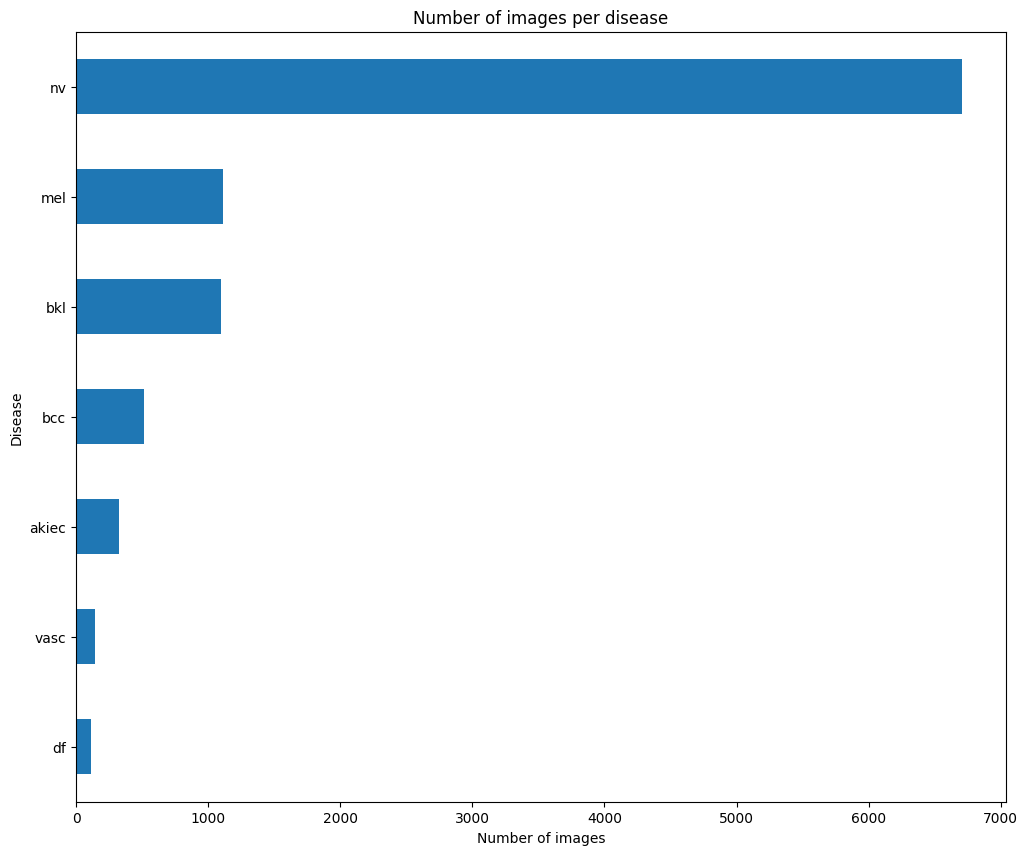

In [ ]:
ham_df['dx'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize = (12, 10))
plt.title("Number of images per disease")
plt.xlabel("Number of images")
plt.ylabel("Disease")
plt.show()

In [ ]:
# path to zip files
zip_path_ddi = "/content/drive/MyDrive/Datasets/skin_cancer/DDI/ddidiversedermatologyimages-20231208T172441Z-001.zip"  #Change this here! Link to your ddi.zip

extraction_path = "/content/unzipped_files"

# create directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# unzip files
with zipfile.ZipFile(zip_path_ddi, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# image directory
ddi_img_dir = os.path.join(extraction_path, 'ddidiversedermatologyimages')


# extract metadata
ddi_df = pd.read_csv("/content/drive/MyDrive/Datasets/skin_cancer/DDI/ddi_metadata.csv", index_col = 0) # Wherever the ddi_metadata.csv file is

ddi_df['image_path']= ddi_df['DDI_file'].apply(lambda x: os.path.join(ddi_img_dir, x))

In [ ]:
ddi_df.head()

,DDI_ID,DDI_file,skin_tone,malignant,disease,image_path
0,1,000001.png,56,True,melanoma-in-situ,/content/unzipped_files/ddidiversedermatologyi...
1,2,000002.png,56,True,melanoma-in-situ,/content/unzipped_files/ddidiversedermatologyi...
2,3,000003.png,56,True,mycosis-fungoides,/content/unzipped_files/ddidiversedermatologyi...
3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ,/content/unzipped_files/ddidiversedermatologyi...
4,5,000005.png,12,True,basal-cell-carcinoma,/content/unzipped_files/ddidiversedermatologyi...


In [ ]:
print(ddi_df['malignant'].value_counts())
ddi_df[ddi_df['malignant'] == False]['disease'].unique()

False    485
True     171
Name: malignant, dtype: int64


array(['melanocytic-nevi', 'seborrheic-keratosis-irritated',
       'focal-acral-hyperkeratosis', 'hyperpigmentation', 'lipoma',
       'foreign-body-granuloma', 'blue-nevus', 'verruca-vulgaris',
       'acrochordon', 'wart',
       'abrasions-ulcerations-and-physical-injuries', 'epidermal-cyst',
       'acquired-digital-fibrokeratoma', 'epidermal-nevus',
       'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma',
       'neurofibroma', 'syringocystadenoma-papilliferum',
       'nevus-lipomatosus-superficialis', 'benign-keratosis',
       'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma',
       'trichofolliculoma', 'lymphocytic-infiltrations',
       'prurigo-nodularis', 'scar', 'eccrine-poroma', 'angioleiomyoma',
       'keloid', 'hematoma', 'angioma', 'folliculitis', 'xanthogranuloma',
       'eczema-spongiotic-dermatitis', 'arteriovenous-hemangioma',
       'acne-cystic', 'verruciform-xanthoma', 'molluscum-contagiosum',
       'condyloma-accuminatum', 'mo

In [ ]:
ddi_df['disease'].value_counts()

melanocytic-nevi             119
seborrheic-keratosis          58
verruca-vulgaris              50
basal-cell-carcinoma          41
epidermal-cyst                35
                            ... 
keloid                         1
angioleiomyoma                 1
lymphocytic-infiltrations      1
wart                           1
acral-melanotic-macule         1
Name: disease, Length: 78, dtype: int64

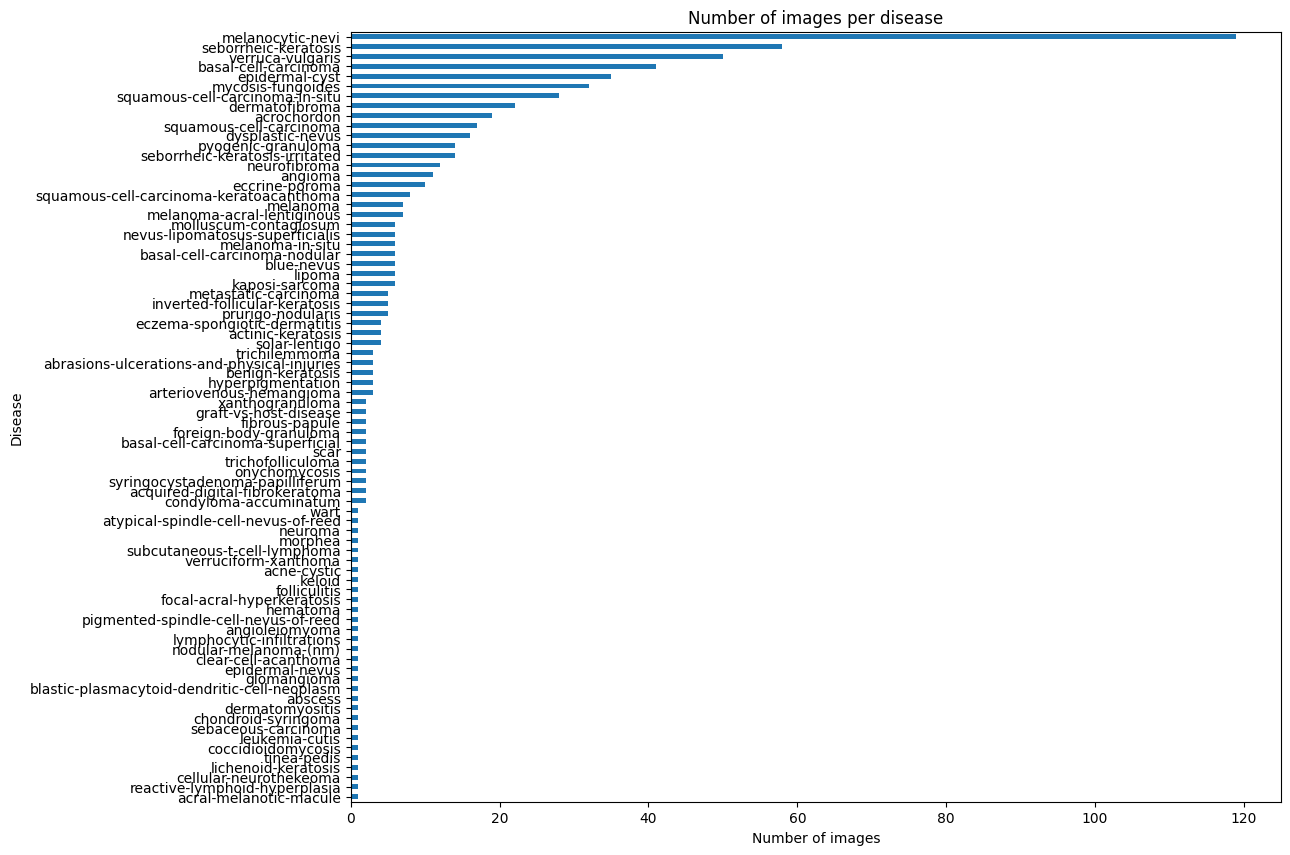

In [ ]:
ddi_df['disease'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize = (12, 10))
plt.title("Number of images per disease")
plt.xlabel("Number of images")
plt.ylabel("Disease")
plt.show()

In [ ]:
ham_df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

akeic - Actinic keratoses and intraepithelial carcinoma / Bowen's disease

bcc - basal cell carcinoma

bkl - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)

df - dermatofibroma

mel - melanoma

nv - melanocytic nevi

vasc - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)


In [ ]:
ddi_df['disease'].unique()

array(['melanoma-in-situ', 'mycosis-fungoides',
       'squamous-cell-carcinoma-in-situ', 'basal-cell-carcinoma',
       'squamous-cell-carcinoma', 'melanoma-acral-lentiginous',
       'basal-cell-carcinoma-superficial',
       'squamous-cell-carcinoma-keratoacanthoma',
       'subcutaneous-t-cell-lymphoma', 'melanocytic-nevi',
       'seborrheic-keratosis-irritated', 'focal-acral-hyperkeratosis',
       'hyperpigmentation', 'lipoma', 'foreign-body-granuloma',
       'blue-nevus', 'verruca-vulgaris', 'acrochordon', 'wart',
       'abrasions-ulcerations-and-physical-injuries',
       'basal-cell-carcinoma-nodular', 'epidermal-cyst',
       'acquired-digital-fibrokeratoma', 'epidermal-nevus',
       'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma',
       'neurofibroma', 'syringocystadenoma-papilliferum',
       'nevus-lipomatosus-superficialis', 'benign-keratosis',
       'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma',
       'trichofolliculoma', 'lympho

The mappings between the two skin cancer datasets involve correlating specific skin conditions from one dataset (which uses more detailed medical terminology) to more generalized categories in the other dataset. Here's an explanation for each of the key mappings:

- **Melanocytic Nevi to 'nv'**: 'Melanocytic nevi' in the second dataset are mapped to 'nv' (melanocytic nevi) in the first dataset. This is a straightforward mapping as both terms refer to the same skin condition, commonly known as moles. These are usually benign (non-cancerous) growths on the skin, formed by clusters of melanocytes, the cells responsible for skin pigment.

- **Basal Cell Carcinoma and its Variants to 'bcc'**: 'Basal-cell-carcinoma', along with its variants 'basal-cell-carcinoma-superficial', and 'basal-cell-carcinoma-nodular', are all mapped to 'bcc' (basal cell carcinoma) in the first dataset. Basal cell carcinoma is a type of skin cancer that begins in the basal cells – a type of cell within the skin that produces new skin cells as old ones die off. It's one of the most common types of skin cancer and tends to occur in areas exposed to the sun.

- **Actinic Keratosis to 'akeic'**: 'Actinic-keratosis' is mapped to 'akeic', which stands for Actinic keratoses and intraepithelial carcinoma (also known as Bowen's disease) in the first dataset. Actinic keratosis is a rough, scaly patch on the skin that develops from years of exposure to the sun. It's considered a precancerous skin lesion that can potentially develop into a more serious form of skin cancer.

- **Melanoma Variants to 'mel'**: Several types of melanoma in the second dataset, including 'melanoma', 'melanoma-in-situ', 'melanoma-acral-lentiginous', and 'nodular-melanoma-(nm)', are mapped to 'mel' (melanoma) in the first dataset. Melanoma is a serious form of skin cancer that develops in the pigment-producing skin cells known as melanocytes. It's known for its ability to spread to other parts of the body and can be more dangerous than other forms of skin cancer if not caught early.

- **Vascular Lesions to 'vasc'**: Conditions like 'angioma', 'arteriovenous-hemangioma', 'pyogenic-granuloma', and 'hematoma' are mapped to 'vasc' (vascular lesions) in the first dataset. These are various types of skin lesions related to blood vessels. For example, angiomas are benign growths that consist of small blood vessels, while pyogenic granulomas are small, reddish bumps on the skin that bleed easily due to a high number of blood vessels.

- **Benign Keratosis-Like Lesions to 'bkl'**: Skin conditions such as 'seborrheic-keratosis', 'seborrheic-keratosis-irritated', and 'lichenoid-keratosis' are mapped to 'bkl' (benign keratosis-like lesions) in the first dataset. These conditions include various types of non-cancerous growths like seborrheic keratoses, which are common skin growths that appear in adulthood, and lichenoid keratosis, a benign lesion that may resemble a lichen planus lesion.

In [ ]:
ham_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,malignant
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0027419.jpg,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0025030.jpg,False
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0026769.jpg,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/unzipped_files/ham10k/ISIC_0025661.jpg,False
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/unzipped_files/ham10k/ISIC_0031633.jpg,False


In [ ]:
ddi_to_ham_labels = {
    "melanocytic-nevi": "nv",
    "basal-cell-carcinoma": "bcc",
    "basal-cell-carcinoma-superficial": "bcc",
    "basal-cell-carcinoma-nodular": "bcc",
    "actinic-keratosis": "akeic",
    "melanoma": "mel",
    "melanoma-in-situ": "mel",
    "melanoma-acral-lentiginous": "mel",
    "nodular-melanoma-(nm)": "mel",
    "angioma": "vasc",
    "arteriovenous-hemangioma": "vasc",
    "pyogenic-granuloma": "vasc",
    "hematoma": "vasc",
    "seborrheic-keratosis": "bkl",
    "seborrheic-keratosis-irritated": "bkl",
    "lichenoid-keratosis": "bkl"
}

In [ ]:
ddi_df['dx'] = ddi_df['disease'].map(ddi_to_ham_labels)
ddi_df['dx'].value_counts()

nv       119
bkl       73
bcc       49
vasc      29
mel       21
akeic      4
Name: dx, dtype: int64

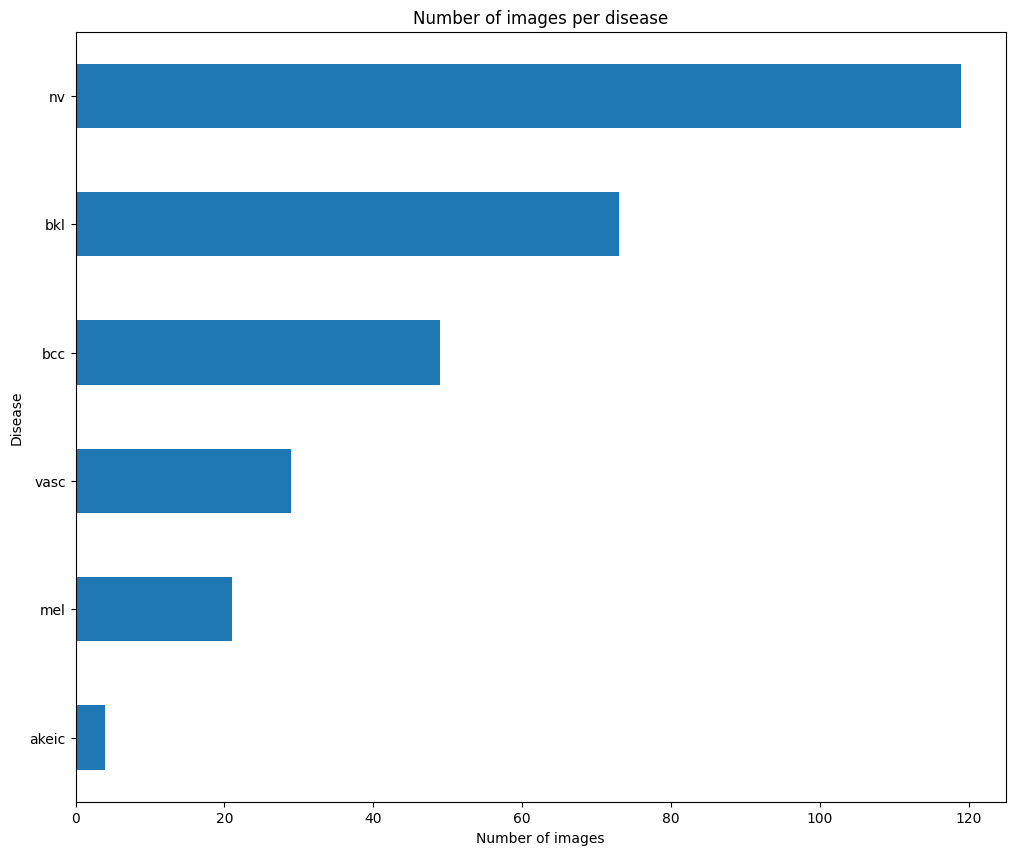

In [ ]:
ddi_df['dx'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize = (12, 10))
plt.title("Number of images per disease")
plt.xlabel("Number of images")
plt.ylabel("Disease")
plt.show()

In [ ]:
# Train on the ham df
# the data generators expects the 'binary' class values to be strings
ham_df['malignant'] = ham_df['malignant'].astype(str)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ham_df, test_size=0.2)

test_df, val_df = train_test_split(test_df, test_size=0.5)

print(train_df.shape, val_df.shape, test_df.shape)

(8012, 9) (1002, 9) (1001, 9)


In [ ]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,malignant
1487,HAM_0000179,ISIC_0033700,mel,histo,45.0,male,back,/content/unzipped_files/ham10k/ISIC_0033700.jpg,True
3968,HAM_0002035,ISIC_0024989,nv,follow_up,45.0,female,upper extremity,/content/unzipped_files/ham10k/ISIC_0024989.jpg,False
6619,HAM_0004280,ISIC_0030905,nv,follow_up,50.0,male,back,/content/unzipped_files/ham10k/ISIC_0030905.jpg,False
2275,HAM_0003171,ISIC_0030122,mel,histo,55.0,male,back,/content/unzipped_files/ham10k/ISIC_0030122.jpg,True
8319,HAM_0001157,ISIC_0027423,nv,histo,65.0,male,upper extremity,/content/unzipped_files/ham10k/ISIC_0027423.jpg,False


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for training with extensive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=45,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly horizontal shift images (fraction of total width)
    height_shift_range=0.2,  # Randomly vertical shift images (fraction of total height)
    shear_range=0.2,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,  # Randomly zoom image
    channel_shift_range=20,  # Randomly shift the color channels
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    fill_mode='nearest',  # Strategy used for filling in newly created pixels
    brightness_range=[0.8,1.2]  # Randomly change brightness (darker < 1 < brighter)
)

# Create a data generator from the DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',  # Column in DataFrame that contains the image paths
    y_col='dx',         # Column in DataFrame that contains the labels
    target_size=(299, 299),  # Resize images to 224x224 for VGG-16, 299x299 for InceptionV3
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification/ 'binary' otherwise
)

# Define ImageDataGenerator for validation and testing (without data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale the pixel values

# Create a data generator for the validation set
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',  # Column in DataFrame that contains the image paths
    y_col='dx',         # Column in DataFrame that contains the labels
    target_size=(299, 299),  # Resize images to 224x224 for VGG-16, 299x299 for InceptionV3
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification/ 'binary' otherwise
    shuffle=False  # Do not shuffle data for validation/testing
)

# Create a data generator for the test set
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(299, 299),# Resize images to 224x224 for VGG-16, 299x299 for InceptionV3
    batch_size=32,
    class_mode='categorical', # Use 'categorical' for multi-class classification/ 'binary' otherwise
    shuffle=False
)

Found 8012 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 with pre-trained ImageNet weights, exclude the top fully connected layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Let's say we want to unfreeze the top few layers for fine-tuning
# Calculate which layer to start unfreezing from
num_layers_to_unfreeze = int(len(base_model.layers) * 0.2)
layers_to_unfreeze = base_model.layers[-num_layers_to_unfreeze:]

# Freeze all the layers of the base model first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers for fine-tuning
for layer in layers_to_unfreeze:
    layer.trainable = True

# Add custom layers on top for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Use sigmoid for binary classification, softmax otherwise

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a binary_crossentropy loss and an appropriate optimizer
model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to monitor (change to 'val_accuracy' if desired)
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To log when training is being stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # You can set this higher since early stopping is being used
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]  # Include early stopping here
)


Epoch 1/50
250/250 [==============================] - 296s 1s/step - loss: 0.8357 - accuracy: 0.7036 - val_loss: 0.6455 - val_accuracy: 0.7772
Epoch 2/50
250/250 [==============================] - 280s 1s/step - loss: 0.6358 - accuracy: 0.7706 - val_loss: 0.5570 - val_accuracy: 0.7954
Epoch 3/50
250/250 [==============================] - 280s 1s/step - loss: 0.5606 - accuracy: 0.7992 - val_loss: 0.5220 - val_accuracy: 0.8175
Epoch 4/50
250/250 [==============================] - 278s 1s/step - loss: 0.5095 - accuracy: 0.8099 - val_loss: 0.5440 - val_accuracy: 0.8034
Epoch 5/50
250/250 [==============================] - 280s 1s/step - loss: 0.4605 - accuracy: 0.8316 - val_loss: 0.5340 - val_accuracy: 0.8115
Epoch 6/50
250/250 [==============================] - 286s 1s/step - loss: 0.4102 - accuracy: 0.8475 - val_loss: 0.5359 - val_accuracy: 0.8236
Epoch 7/50
250/250 [==============================] - 290s 1s/step - loss: 0.3910 - accuracy: 0.8560 - val_loss: 0.5976 - val_accuracy: 0.8075

In [ ]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

31/31 [==============================] - 10s 333ms/step - loss: 0.6664 - accuracy: 0.7712
Test accuracy: 0.7711693644523621, Test loss: 0.6664416790008545


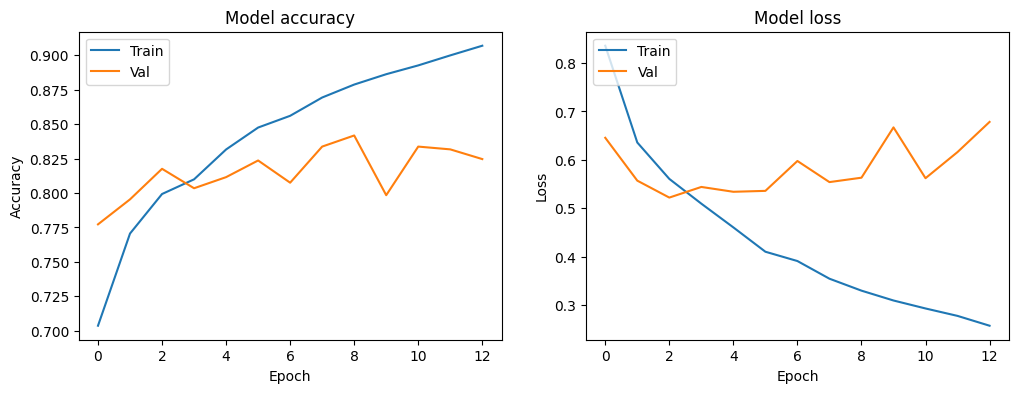

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


32/32 [==============================] - 12s 307ms/step
              precision    recall  f1-score   support

       akiec       0.60      0.30      0.40        40
         bcc       0.74      0.51      0.60        51
         bkl       0.49      0.56      0.52       117
          df       0.33      0.07      0.11        15
         mel       0.49      0.37      0.42       115
          nv       0.86      0.94      0.90       649
        vasc       0.64      0.64      0.64        14

    accuracy                           0.77      1001
   macro avg       0.59      0.48      0.51      1001
weighted avg       0.75      0.77      0.75      1001



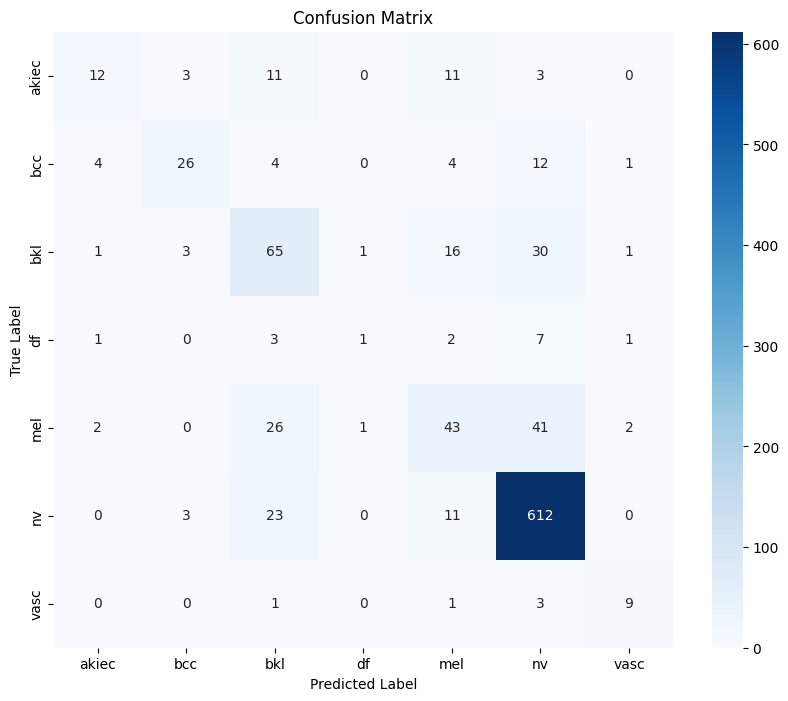

In [ ]:

# Reset the test generator
test_generator.reset()

# Predict the labels for all samples
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=-1)

# Get the class indices
class_indices = test_generator.class_indices

# Assuming 'test_df' is your test DataFrame and it's in the same order as the test generator
true_classes = test_df['dx'].apply(lambda x: class_indices[x]).values

# Reverse the class indices to get a mapping from index to class name
label_map = dict((v, k) for k, v in class_indices.items())
true_class_names = [label_map[i] for i in true_classes]
predicted_class_names = [label_map[i] for i in predicted_classes]

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=label_map.values()))

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()